Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your github nickname below:

In [1]:
NICKNAME = "Myza Alexandr"

---

# Часть 1. Гауссовы квадратуры

Метод Гауссовых квадратур является одним из методов численного интегрирования, который позволяет увеличить точность интегрирования, используя ортогональные полиномы и их корни в качестве узлов.

$$
\int_a^b \!  w(x)\, f(x)\, dx \approx \sum_{k=1}^n w_k \, f(x_k) \;,
$$

здесь $\omega$ - функция весов, которая определят базис ортогональных полиномов, чьи корни используются в качестве узлов интегрирования. 

Получаемая таким образом квадратурная схема *точно* инегрирует $f(x)$ если это полином степени $m\le2n-1$, где $n$ - степень полинома, корни которого используются в качестве узлов.

## Двухточечная квадратура Гаусса

Постройте квадратурную формулу Гаусса, интегрирующую точно многочлены степеней вплоть до третьей на интервале $[a, b]$. Заметим, что для этого достаточно построить _двухточечную_ квадратуру.

    hint:Легко найти точки и веса для отрезка [-1,1], после чего можно сделать аффинное преобразование..

Напишите функцию, которая возвращает веса, $w_1$ и $w_2$, и узлы, $x_1$ и $x_2$, двухточечной квадратурной формулы Гаусса с весовой функцией $w(x) = 1$, т.е., интегралы вида

$$
\int_a^b\! f(x)\, dx \approx w_1 f(x_1) + w_2 f(x_2)
$$

In [2]:
import scipy as sc
import numpy as np
import sympy as smp
from scipy.optimize import fsolve
def gauss_2(a, b):
    ans = lambda i: (b ** i - a ** i) / i
    def func(x):
      args = {'x1': x[0],
              'x2': x[1],
              'w1': x[2],
              'w2': x[3]}
      x = np.asarray([args['x1'], args['x2']])
      w = np.asarray([args['w1'], args['w2']])
      return [
              w.sum() - ans(1),
              (w * x).sum() - ans(2),
              (w * x ** 2).sum() - ans(3),
              (w * x ** 3).sum() - ans(4)
              ]
    x_w = fsolve(func, [a, a, b - a, b - a])
    return x_w

In [3]:
from numpy.testing import assert_allclose

x1, x2, w1, w2 = gauss_2(0, 1)

def f(x, n): 
    return x**n

for n in [0, 1, 2, 3]:
    assert_allclose(w1*f(x1, n=n) + w2*f(x2, n=n),
                    1./(n+1), atol=1e-14)

## Использование ортогональных полиномов

### Legendre

Теперь посчитаем следующий интеграл:

$$
\int_{-1}^1 (7x^3 - 8 x^2 - 3 x + 3) dx  \label{eq1}\tag{1}
$$

Здесь функция уже полиномиальна, поэтому возьмем весовую функцию $\omega(x) = 1$. Тогда вычисление интеграла сводится к сумме корней полинома, соответствующих весовой функции $\omega(x) = 1$. Например, здесь https://dlmf.nist.gov/18.3 вы можете увидеть, какой базис полиномов соответствует вашей весовой функции.

Заметим, что нашей соответствуют полиномы Лежандра. Теперь, зайдем в документацию https://docs.scipy.org/doc/scipy/reference/special.html#orthogonal-polynomials. Функция *roots_legendre* сразу же выдаст корни полиномов Лежандра, а также веса к их корням (для полиномов Лежандра все эти веса равны единице).

1. Посчитайте точное значение интеграла ([1](#mjx-eqn-eq1)) "руками".

In [4]:
a = -1
b = 1
F = lambda x: 7/4*x**4-8/3*x**3-3/2*x**2+3*x
print(F(b)-F(a))

0.6666666666666674


2. Посчитайте значение интеграла ([1](#mjx-eqn-eq1)), используя обычный метод интегрирования на равномерной сетке (например, написанный вами в предыдущем дз). Оцените количество узлов, необходимых для достижения относительной точности $10^{-10}$.

In [5]:
def midpoint_method(func, a, b, n):
    h = (b - a) / n
    ans = 0.0
    x_0 = a + 0.5 * h
    for i in range(n):
        ans += func(x_0 + i * h)
    return ans * h
def trapezoid_method(func, a, b, delta, n=1):
    h = (b - a) / n
    ans_p = 0.0
    ans_dr = 0.5 * (func(a) + func(b))
    for i in range(1, n):
        ans_dr += func(a + i * h)
    ans_dr *= h
    error = max(1, abs(ans_dr))
    while error > abs(delta * ans_dr):
        ans_p = ans_dr
        ans_dr = 0.5 * (ans_dr + midpoint_method(func, a, b, n)) 
        n *= 2
        error = abs(ans_dr - ans_p)
    return ans_dr, n + 1
f = lambda x: 7*x**3-8*x**2-3*x+3
ans, points_count = trapezoid_method(f, -1, 1, delta = 1e-10)
print(f'Результат {ans}, кол-во узлов: {points_count}')

Результат 0.6666666666569454, кол-во узлов: 1048577


3. Посчитайте значение интеграла ([1](#mjx-eqn-eq1)), с помощью Гауссовой квадратуры (используя корни полинома Лежандра степени от 1 до 6 в качестве узлов) (чтобы получить корни и веса используйте scipy.special.roots_legendre)

In [6]:
for n in range(1,7):
    n, w = sc.special.roots_legendre(n)

    print((f(n) * w).sum())

6.0
0.6666666666666674
0.6666666666666639
0.6666666666666667
0.6666666666666685
0.6666666666666695


Сравните количество узлов, необходимых для достижения одинаковой точности в обоих чисенных методах.

In [7]:
from scipy.special import roots_legendre
def quad_legendre(f, delta):
    ans = 1000
    i = 0
    while abs(ans - 2/3) > 2/3 * delta:
        i += 1
        roots, w = roots_legendre(i)
        ans = f(roots).dot(w)
    return ans, i
f = lambda x: 7*x**3-8*x**2-3*x+3
print( '2 столб-метод Гаусса'.center(14), '     3 столб-метод трапеции'.center(14))
for i in range(1, 13):
    ans_gq, points_count_gq = quad_legendre(f, delta = 10 **(-i))
    ans_tr, points_count_tr = trapezoid_method(f, -1, 1, delta = 10 **(-i))
    print(f'1e-{i}', f'{points_count_gq}', f'{points_count_tr}')

2 столб-метод Гаусса      3 столб-метод трапеции
1e-1 2 33
1e-2 2 129
1e-3 2 257
1e-4 2 1025
1e-5 2 4097
1e-6 2 8193
1e-7 2 32769
1e-8 2 131073
1e-9 2 262145
1e-10 2 1048577
1e-11 2 4194305
1e-12 2 8388609



Вычислите значение того же интеграла, но на интервале от 0 до 10.

$$
\int_{0}^{10} (7x^3 - 8 x^2 - 3 x + 3) dx 
$$

Заметим, что больше нельзя использовать полиномы Лежанда, потому что они определены на интервале (-1, 1). Однако всегда можно произвести *аффинное преобразование* для того, чтобы перейти к желаемой системе координат.

(20% итоговой оценки)

In [8]:
a = 0
b = 10
f = lambda x: 7*x**3-8*x**2-3*x+3
root, w = roots_legendre(6)
t = (b - a) / 2 * root + (a + b) / 2
ans = (b - a) / 2 * f(t).dot(w)
print( {ans})

{14713.333333333336}


Сравните результат с точным значением интеграла.

Если считать руками то ответ с высокой точностью равен реальному

### 

Вычислите значение следующиего интеграла:
$$
\int_{0}^{2\pi} \frac{cos(x) dx }{\sqrt{4\pi^2 - x^2}}
$$
используя соответствующий базис ортогональных полиномов.
Найдите степень полинома (количество узлов), при которой точность превысит машинное $\epsilon$.


In [9]:
from scipy.special import roots_chebyt
import numpy as np
f = lambda y: np.cos(2 * np.pi * y)
eps = 1e-16
i = 1
ans = 10000
r_ans = 0.34601015881226444
while abs(ans - r_ans) >= eps:
    roots, w = roots_chebyt(i)
    ans = 0.5 * f(roots).dot(w)
    i += 1
print(f'Степень  {i}, результат : {ans}')

Степень  17, результат : 0.3460101588122644


# Часть 2. Уравение Фредгольма

Существует два типа уравнений Фредгольма: 

1. Уравение Фредгольма первого рода:
$$
\int_a^b \! K(x, t)\, \color{blue}{f(t)} \,dt = g(x)
$$

2. Уравнение Фредгольма второго рода:
$$
\lambda \int_a^b\! K(x, t)\, \color{blue}{f(t)} \, dt + g(x) = \color{blue}{f(x)}
$$

Здесь функция $f(x)$ неизвестна, $K(x, t)$ - ядро уравнения, заданная функция $g(x)$ и $\lambda$ - рациональное число.
С точки зрения вычислений, уравение Фредгольма первого рода крайне неустойчиво. Далее мы рассмотрим только уравнение второго рода.

Основная идея - аппроксимировать интеграл некой квадратурной формулой

$$
\int_a^b \! \xi(t)\, dt \approx \sum_j^N w_j\, \xi(t_j)
$$

с подходящими весами $w_j$ и узлами $t_j$, $j=1, \dots, N$. Точность аппроксимации контролируется $N$.

Таким образом, уравнение Фредгольма приближается следующим образом:

$$
\lambda \sum_j w_j\, K(x, t_j)\, \color{blue}{f(t_j)} + g(x) = \color{blue}{f(x)}
$$

Отметим, что $x$ - непрерывная переменная, в то время, как $t$ - дискретная.

Рассматривая данное уравнение на тех же узлах сетки $x = t_k$, получаем

$$
\lambda \sum_j w_j \, K_{k, j}\, \color{blue}{f_j} + g_k = \color{blue}{f_k}
$$

где $f_j \equiv f(t_j)$, $g_j \equiv g(t_j)$ and $K_{k, j} \equiv K(t_k, t_j)$. Это ничто иное, как система линейных алгебраических уравнений на вектор $\color{blue}{f_j}$.

Ее решение выдает значение неизвестной функции $f(x)$ в дискретных точках $x=t_j$ для $j=1, \dots, N$.


Решите предложенное уравнение Фредгольма второго рода

$$
f(x) = \cos(x)  + \frac{1}{2\pi} \int_0^\pi \! \sin(x) \,t f(t) \, dt
$$

Здесь $a, b = 0, 1$, $\lambda = \dfrac{1}{2\pi}$, ядро $K(x, t) = \sin(x)\cdot t$ и правая часть - $g(x) = \cos(x)$.

Точное решение (Сборник задач по интегральным уравнениям, 2006):

$$
f(x) = \cos(x)- \frac{2}{\pi}\sin(x)
$$

Для нахождения интеграла преобразуйте заменой переменных в интеграле область интегрирования в [0,1] воспользуйтесь Гауссовой квадратурой с весовой функцией $w(x) = 1$ на $(0, 1)$. Посмотрите на http://dlmf.nist.gov/18.3, и найдите соответствующую функцию в *scipy.special* (обратите внимание на область интегрирования).

Напишите функцию, возвращающую значение f(t_j) по схеме выше, которая в качестве параметра принимает величину $N$--число узлов в квадратуре, для нахождение решения СЛАУ можно использовать `scipy.linalg.solve`.

Постройте график истинного решения и набор (t_j, f_j) для раличных $N$, используя вашу функцию.

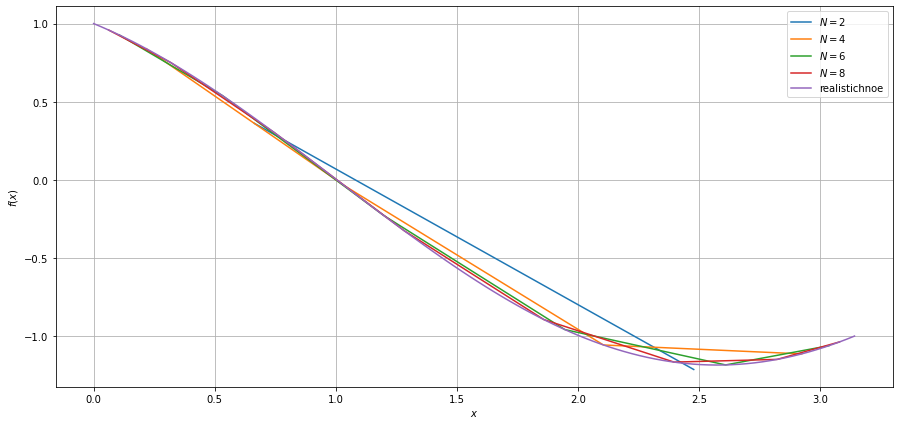

In [10]:
from scipy.special import roots_sh_legendre
from scipy.linalg import solve
import matplotlib.pyplot as plt
import numpy as np
def returner(N):
    roots, w = roots_sh_legendre(N)
    l = np.pi * 0.5
    K = lambda t_k, t_j: np.sin(np.pi * t_k) * t_j
    g = lambda x: np.cos(np.pi * x)
    I = np.eye(N)
    matrix_K = l * np.asarray([w * K(t_k, roots) for t_k in roots]) - I
    matrix_minus_g = - g(roots)
    f = solve(matrix_K, matrix_minus_g)
    return f
plt.figure(figsize=(15, 7))
plt.grid(True)
plt.xlabel(r'$x$')
plt.ylabel(r'$f(x)$')
for N in range(2, 10, 2):
    roots, w = roots_sh_legendre(N)
    x = roots * np.pi
    f = returner(N)
    plt.plot(x, f, label=f'$N = {N}$')
real_f = lambda x: np.cos(x) - (2 / np.pi) * np.sin(x)
x = np.linspace(0, np.pi, 100)
plt.plot(x, real_f(x), label='realistichnoe')
plt.legend(loc="best")

Очевидной проблемой предыдущего результата для $f(x)$ является то, что он возвращает решения на фиксированном наборе точек. Мы не контролируем их расположение.

Оказывается, интерполяционные методы (мы обсудим их на следующих занятиях) работают не очень хорошо, в сравнении с следующим подходом:

Используйте изначальный вид, чтобы вычислить значение функции на всём интервале:

$$
f(x) = g(x) + \lambda \sum_j^N w_j\, K(x, t_j)\, f(t_j)
$$

Сравните эту интерполяцию с точным решением для разлиных $N$.
(выбирайте наглядный масштаб)

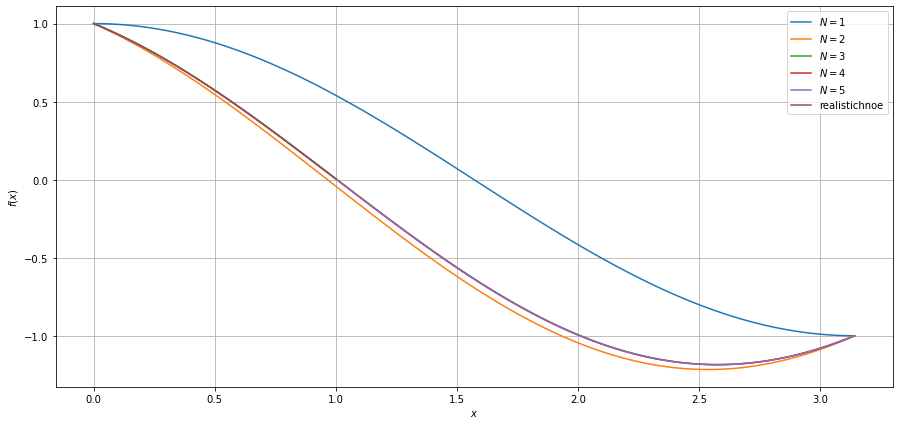

In [11]:
plt.figure(figsize=(15, 7))
plt.grid(True)
plt.xlabel(r'$x$')
plt.ylabel(r'$f(x)$')
l = 0.5 * np.pi
K = lambda t_k, t_j: np.sin(np.pi * t_k) * t_j
x = np.linspace(0, 1, 100)
g = lambda x: np.cos(np.pi * x)
for N in range(1, 6):
    roots, w = roots_sh_legendre(N)
    hat_f = returner(N)

    f = lambda x: g(x) + l * (w * K(x, roots) * hat_f).sum()
    result_f = np.asarray([f(y) for y in x])

    plt.plot(x * np.pi, result_f, label=f'$N = {N}$')
real_f = lambda x: np.cos(x) - (2 / np.pi) * np.sin(x)
plt.plot(x, real_f(x), label='realistichnoe')
plt.legend(loc="best")

# Часть 3. Интеграл от осциллирующей функции - EXTRA points task

Рассмотрим определенный интеграл

$$
I = \int_0^\infty\! \frac{\sin(x) \cos{(\cos{(x)})}}{x}\,dx
$$

Вычислите значение данного интеграла с относительной точностью $10^{-6}$. Для упрощения задачи можете воспользоваться функционалом `scipy.integrate.quad`.

Заметим, что "из коробки" интеграл вычислить не удается, и нужно что-то придумать.

In [12]:
from math import sin, cos

from scipy.integrate import quad
quad(lambda x: sin(x) * cos(cos(x)) / x, 0, float('inf'))

C:\Users\User-1\AppData\Local\Temp\ipykernel_9728\778045123.py:4: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad(lambda x: sin(x) * cos(cos(x)) / x, 0, float('inf'))


(1.9653912540956702, 4.089174284042293)

Напишите функцию, которая возвращает значение данного интеграла. Только само значение интеграла, без оценки погрешности.
(оборачиваем интеграл в функцию только для удобства автопроверки).

In [13]:
from scipy.integrate import quad

def integ():
    """Return a single float, the computed value of the integral."""
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
from numpy.testing import assert_allclose

# this is a test cell, keep it intact
